# 확정된 상 -> 하반기 세그먼트를 예측하는 모델

1. AutoML인 FLAML로 lightgbm classifier를 찾아본다.

2. 찾아진 모델에서 피쳐 중요도를 분석해본다.

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import tqdm
# from datasets import load_dataset, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
from typing import List, Optional, Tuple, Union
import argparse
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
#@title 마이너 패키지 로딩
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
sns.set(font="NanumGothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize': (10,6)},
        style='darkgrid')

from IPython.display import display, HTML

In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report

import lightgbm as lgb

# 데이터 로딩

In [4]:
df_user_merged = pd.read_csv('csv_user_merged_copPlus.csv')

In [5]:
cat_features = ['ma_fem_dv', 'ages', 'zon_hlv', 'label']

for i in enumerate (cat_features) :
    ca = i[1]
    df_user_merged[ca] = df_user_merged[ca].astype('category')
    df_user_merged[ca] = df_user_merged[ca].astype('category')

In [6]:
target_col = 'label'

In [7]:
df_user_merged = df_user_merged.drop(['grade_first','grade_second', 'cust_no'], axis=1).set_index('cust')

In [8]:
df_train, df_test = train_test_split(df_user_merged, test_size=0.2, random_state=0)

In [9]:
y_train = df_train[target_col]
y_test = df_test[target_col]

In [10]:
x_train = df_train.drop(target_col, axis=1)
x_test = df_test.drop(target_col, axis=1)

# 학습

In [11]:
import ray

In [12]:
from flaml import AutoML
automl = AutoML()

In [13]:
# ray.shutdown()

In [14]:
ray.init(num_cpus=12)

2022-08-10 10:09:44,336	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8267


RayContext(dashboard_url='127.0.0.1:8267', python_version='3.6.9', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.17.0.2', 'raylet_ip_address': '172.17.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-10_10-09-41_690501_29507/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-10_10-09-41_690501_29507/sockets/raylet', 'webui_url': '127.0.0.1:8267', 'session_dir': '/tmp/ray/session_2022-08-10_10-09-41_690501_29507', 'metrics_export_port': 61700, 'gcs_address': '172.17.0.2:51484', 'address': '172.17.0.2:51484', 'node_id': 'bff0060dc895e2f2f5ec6b5ccacb74c7f85af4fc65c9ef043cd6c514'})

In [15]:
automl.fit(x_train, y_train, task="classification", time_budget=3600*5, n_jobs=6, n_concurrent_trials=2, log_file_name='segment_automl.log', estimator_list=["lgbm"])

2022-08-10 15:12:48,450	INFO tune.py:748 -- Total run time: 18135.67 seconds (18004.59 seconds for the tuning loop).
[flaml.automl: 08-10 15:12:49] {3311} INFO - selected model: None
[flaml.automl: 08-10 15:13:13] {3456} INFO - retrain lgbm for 24.0s
[flaml.automl: 08-10 15:13:13] {3461} INFO - retrained model: LGBMClassifier(colsample_bytree=0.6492182214919888,
               learning_rate=0.018951508635514553, max_bin=63,
               min_child_samples=2, n_estimators=1396, n_jobs=6, num_leaves=4,
               reg_alpha=0.5607567989480035, reg_lambda=0.0009765625,
               verbose=-1)
[flaml.automl: 08-10 15:13:13] {2739} INFO - fit succeeded
[flaml.automl: 08-10 15:13:13] {2741} INFO - Time taken to find the best model: 15635.808030366898
[flaml.automl: 08-10 15:13:13] {2755} WARNING - Time taken to find the best model is 87% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


## 베스트 탐색 결과

```               
LGBMClassifier(colsample_bytree=0.6492182214919888,
               learning_rate=0.018951508635514553, max_bin=63,
               min_child_samples=2, n_estimators=1396, n_jobs=6, num_leaves=4,
               reg_alpha=0.5607567989480035, reg_lambda=0.0009765625,
               verbose=-1)
```

In [16]:
print('Best hyperparmeter config:', automl.best_config)
print('Best loss on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 1396, 'num_leaves': 4, 'min_child_samples': 2, 'learning_rate': 0.018951508635514553, 'log_max_bin': 6, 'colsample_bytree': 0.6492182214919888, 'reg_alpha': 0.5607567989480035, 'reg_lambda': 0.0009765625, 'learner': 'lgbm'}
Best loss on validation data: 1.716
Training duration of best run: 23.97 s
LGBMClassifier(colsample_bytree=0.6492182214919888,
               learning_rate=0.018951508635514553, max_bin=63,
               min_child_samples=2, n_estimators=1396, n_jobs=6, num_leaves=4,
               reg_alpha=0.5607567989480035, reg_lambda=0.0009765625,
               verbose=-1)


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


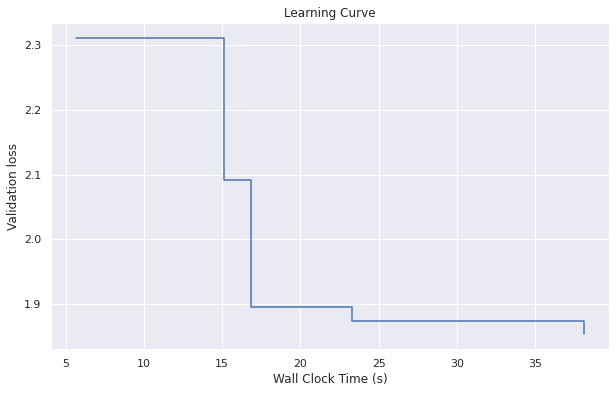

In [17]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='segment_automl.log', time_budget=60)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation loss")
plt.step(time_history, np.array(best_valid_loss_history), where="post")
plt.show()

In [18]:
y_pred = automl.predict(x_test)

# 피쳐 중요도

<AxesSubplot:>

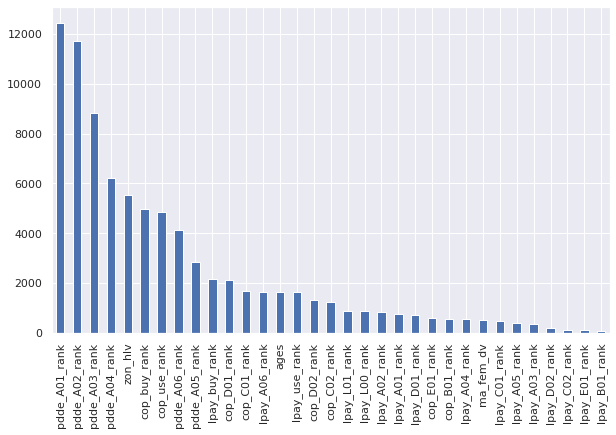

In [19]:
pd.Series(automl.feature_importances_, index=automl.feature_names_in_).sort_values(ascending=False).plot.bar()

# classification-report

분류가 잘되는 두 클래스
- 기타고객/비활동고객의 f1-score: 0.73
- 최우수고객/최우수고객의 f1-score: 0.75

기타고객/비활동고객 분류가 잘됨
- 이들 세그먼트로 예측되는 고객들을 케어할 수 있다.
- 엘페이 결제시 할인 이벤트
    - NCF 추천 알고리즘으로 추천한 상품들 구매시 (이유: 고객이 관심 가질만한 상품 제안이니)

In [20]:
report = classification_report(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [21]:
print(report)

              precision    recall  f1-score   support

   기타고객/기타고객       0.56      0.80      0.66       556
  기타고객/비활동고객       0.70      0.77      0.73       299
   기타고객/우수고객       0.00      0.00      0.00       130
   기타고객/일반고객       0.23      0.19      0.21       245
  기타고객/최우수고객       0.00      0.00      0.00        37
   우수고객/기타고객       0.10      0.01      0.01       132
  우수고객/비활동고객       0.00      0.00      0.00        16
   우수고객/우수고객       0.28      0.57      0.38       587
   우수고객/일반고객       0.17      0.06      0.08       354
  우수고객/최우수고객       0.18      0.08      0.11       383
   일반고객/기타고객       0.23      0.14      0.18       274
  일반고객/비활동고객       0.16      0.04      0.07        71
   일반고객/우수고객       0.14      0.08      0.11       355
   일반고객/일반고객       0.22      0.44      0.30       411
  일반고객/최우수고객       0.00      0.00      0.00       133
  최우수고객/기타고객       0.00      0.00      0.00        30
 최우수고객/비활동고객       0.00      0.00      0.00         3
  최우수고객/우수고객       0.25    